In [1]:
from pathlib import Path
import gc


import matplotlib.pyplot as plt
import matplotlib as mlt
import numpy as np

import os
import scipy
import copy
import glob
import scipy.io as sio



import pandas as pd
from scipy import signal
from scipy.fft import fft, fftfreq

In [2]:
def get_location_markers(index):
    index_label = { 'LSHO':0,
                     'LELB':1,
                    'LWRI':2,
                     'RSHO':3,                                                                
                     'REL':4,
                     'RWRI':5
                     }
    return index_label[index]

def get_data(file_path):
    # 读取 .mat 文件
    data = sio.loadmat(file_path)
    motion_all=data['MotionData']
    
    #换成mins
    time=data['MotionTime'].reshape(-1)/60
    motion_all_data_set = [array[0] for array in motion_all]
    return  motion_all_data_set,time

def get_session_name(file_path):
    #取session name
    file_name_splited = file_path.split('\\')
    session_all_name = file_name_splited [-2]
    session_name = session_all_name.split('_')[0]
    
    return session_name


def plot_motion(data,time,plot_index,session_name):
    #motion_sampling_rate = 120
    motion_index_pooling =[ 'LSHO', 'LELB','LWRI', 'RSHO','REL','RWRI']
    assert plot_index in motion_index_pooling  ,'error: index input'
    
    index = get_location_markers(plot_index)
    
    # 设置图表的大小
    plt.figure(figsize=(8, 6))
    
    # 设置线条宽度
    plt.plot(time, motion_all_data_set[index], linewidth=2,label=['x coordinate ','y coordinate','z coordinate']) 
    
    plt.xlabel('Time (min)', fontsize=12)  # 设置 x 轴标签和字体大小
    plt.ylabel('A.U.', fontsize=12)  # 设置 y 轴标签和字体大小
    plt.title(session_name+'_'+plot_index, fontsize=14)  
    
    
    # 将图例放置在图表外的最佳位置
    plt.legend(frameon=False,loc=[1,1], fontsize=12)

    # 隐藏上边框和右边框
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # 自动调整
    plt.tight_layout() 
    plt.show()


In [3]:
def get_psd(data,sampling_rate,bandwidth,plot_index):
    
    motion_index_pooling =[ 'LSHO', 'LELB','LWRI', 'RSHO','REL','RWRI']
    assert plot_index in motion_index_pooling  ,'error: index input'
    index = get_location_markers(plot_index)
    
    
    # 把t转到最后一个维度
    data = np.transpose(copy.deepcopy(data[index]),[1,0])
    
    # 用raw_data算每个trail里面 spectrogram默认窗口大小256，overlap 八分之一
    f, t, one_trail_psd_3d_spectrogram = signal.spectrogram(data,
                                                            window='hann', 
                                                            fs=sampling_rate, 
                                   scaling='density',#spectrum density
                                   axis=-1, nperseg=512, nfft=4096)  # 512nperseg=1024,
    
    
    # 做频率限制,索引带宽的值的位置
    index_out_100 = np.array(np.where((f >= bandwidth[0]) & (f <= bandwidth[1])))
    
    
    
    #消掉组后的t维度
    one_trail_psd = np.nanmean(one_trail_psd_3d_spectrogram[ :,index_out_100[0],:],axis=-1)
    
    #单位转成dB/Hz
    psd_dB = 10 * np.log10(one_trail_psd)
    
    return f[index_out_100[0]], t,psd_dB




def plot_psd(f,psd):
  
    labels=['x coordinate ','y coordinate','z coordinate']

    plt.plot(f,psd.T,label=labels)
    
    plt.ylabel('PSD (dB/Hz)', fontsize=12)
    plt.xlabel('Frequency (Hz)', fontsize=12)


    #plt.legend(frameon=False,loc=[1,1], fontsize=12)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.show()

# read all session data

找到文件: D:\code\YMa_datasets\food_tracking_data\Epidural\20100623S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6\Motion.mat


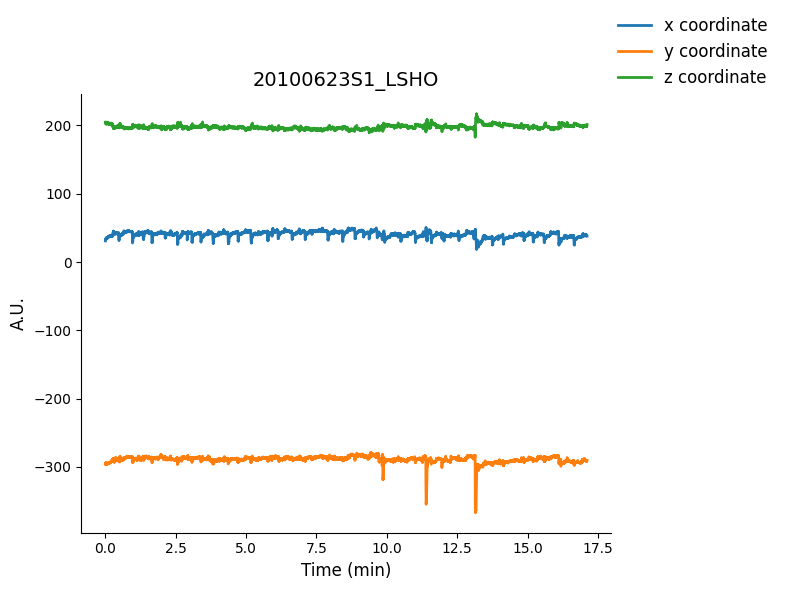

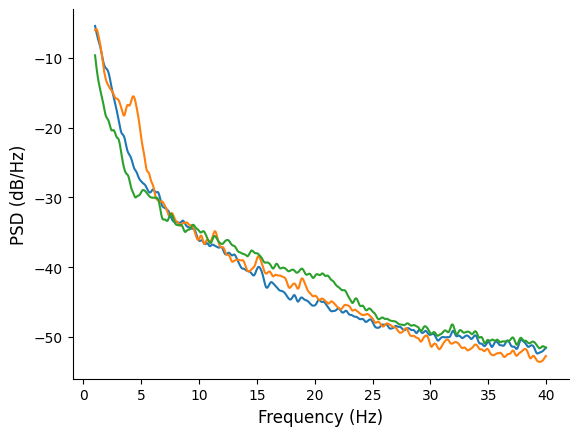

找到文件: D:\code\YMa_datasets\food_tracking_data\Epidural\20100624S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6\Motion.mat


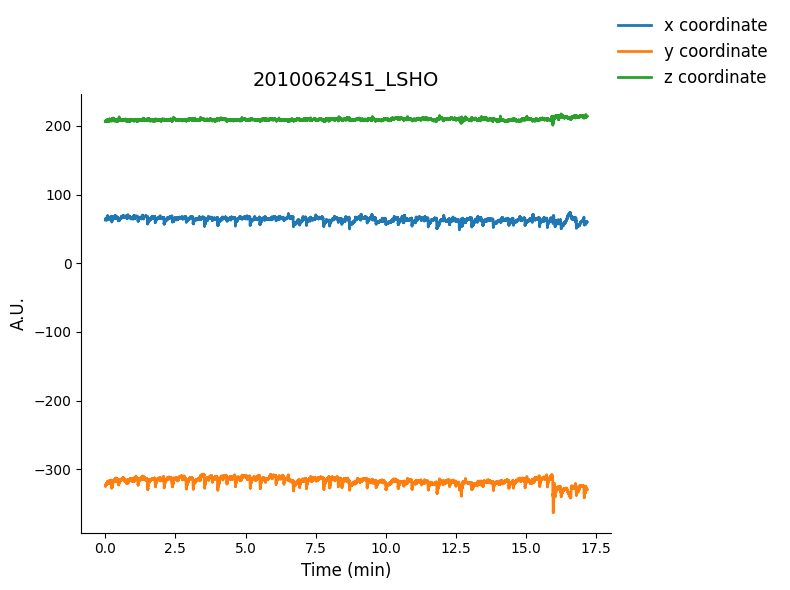

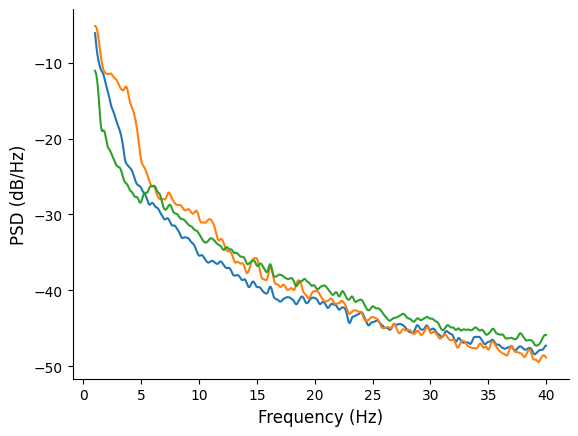

找到文件: D:\code\YMa_datasets\food_tracking_data\Epidural\20100628S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6\Motion.mat


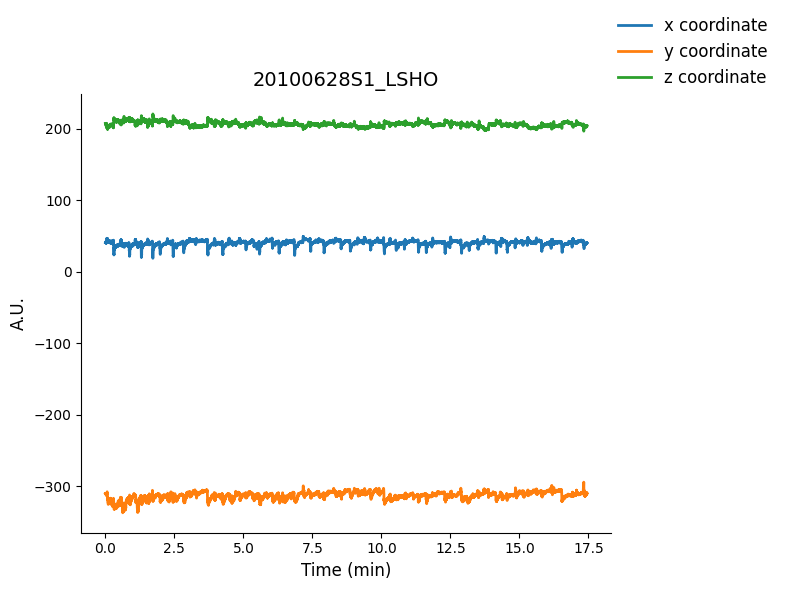

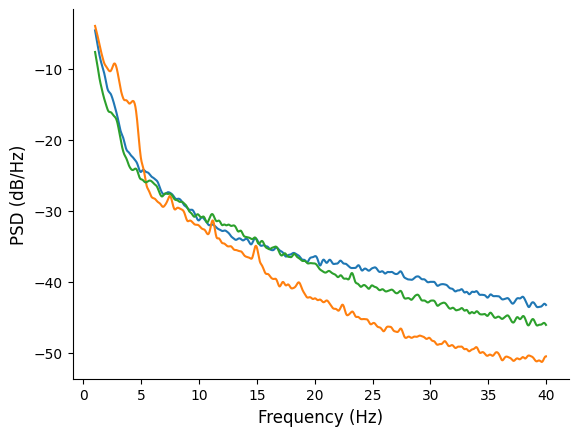

找到文件: D:\code\YMa_datasets\food_tracking_data\Epidural\20100701S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6\Motion.mat


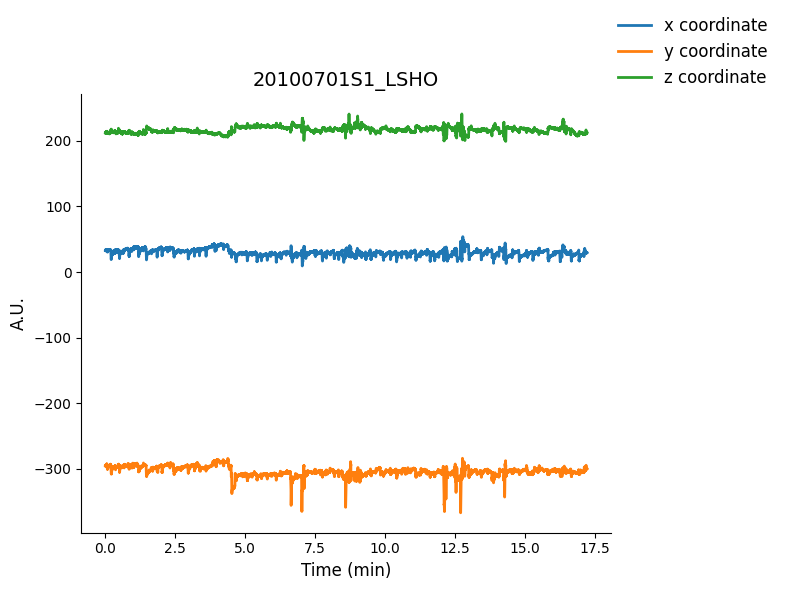

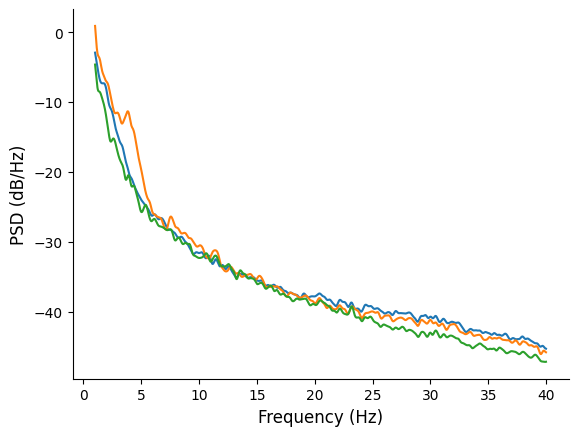

找到文件: D:\code\YMa_datasets\food_tracking_data\Epidural\20100705S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6\Motion.mat


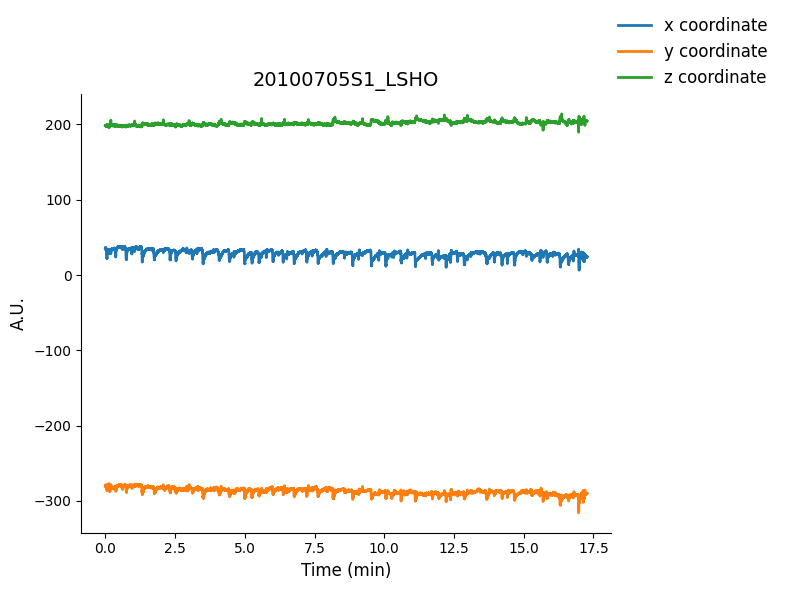

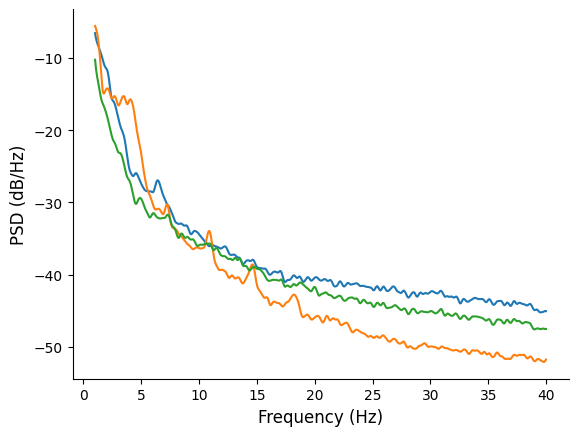

找到文件: D:\code\YMa_datasets\food_tracking_data\Epidural\20100708S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6\Motion.mat


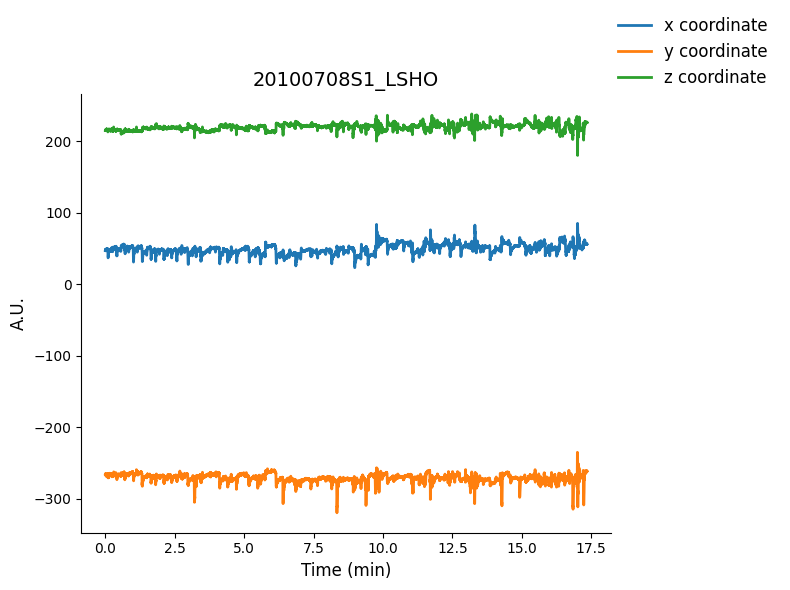

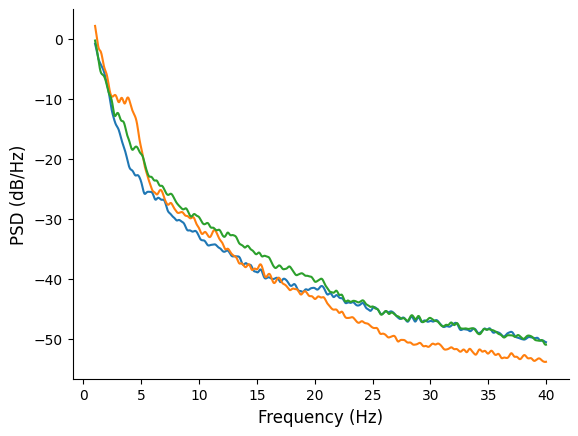

找到文件: D:\code\YMa_datasets\food_tracking_data\Epidural\20100712S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6\Motion.mat


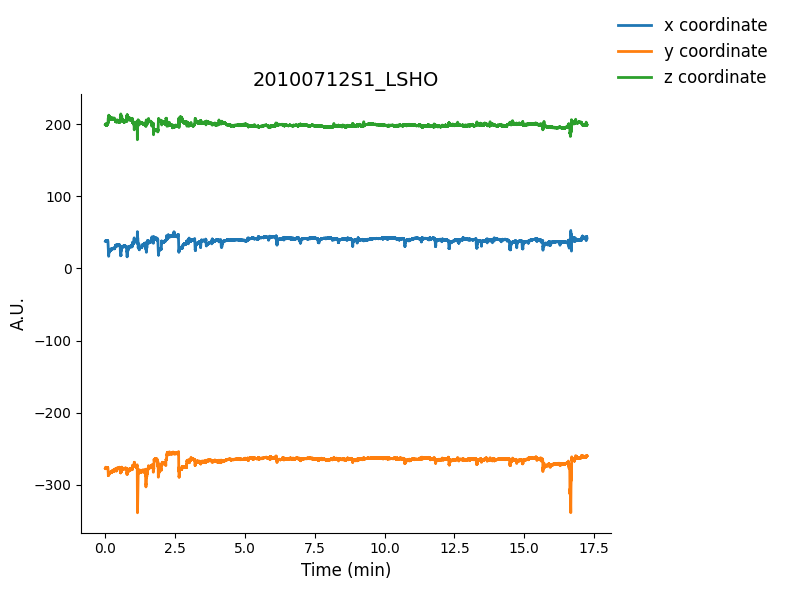

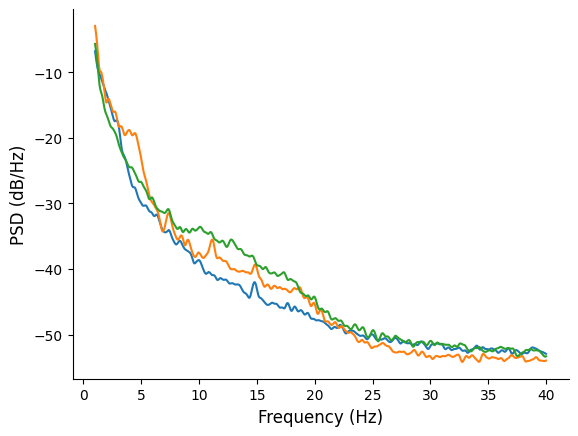

找到文件: D:\code\YMa_datasets\food_tracking_data\Epidural\20100726S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6\Motion.mat


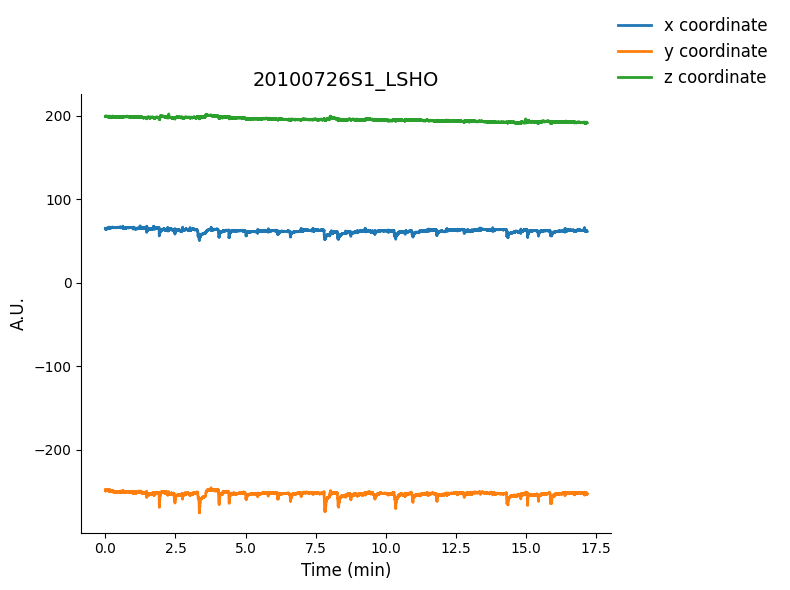

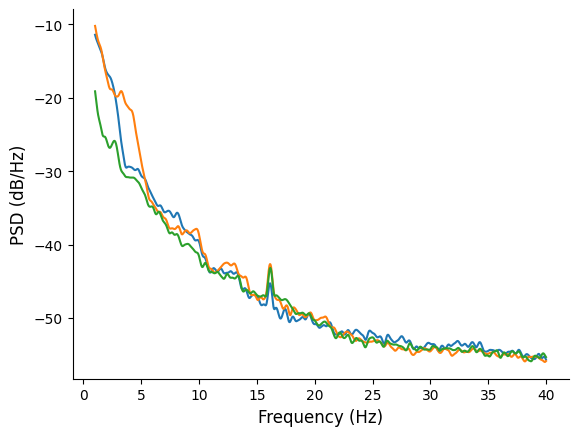

找到文件: D:\code\YMa_datasets\food_tracking_data\Epidural\20100802S1_Epidural-ECoG+Food-Tracking_B_Kentaro+Shimoda_mat_ECoG64-Motion6\Motion.mat


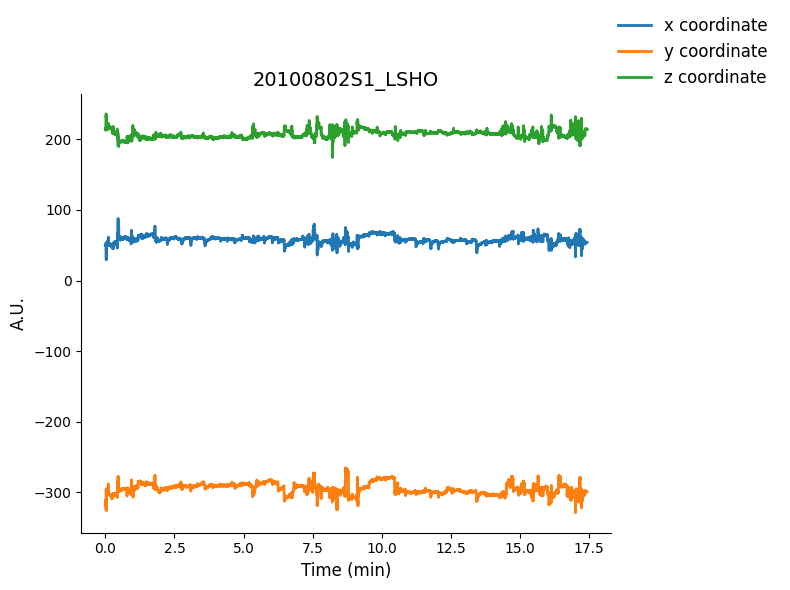

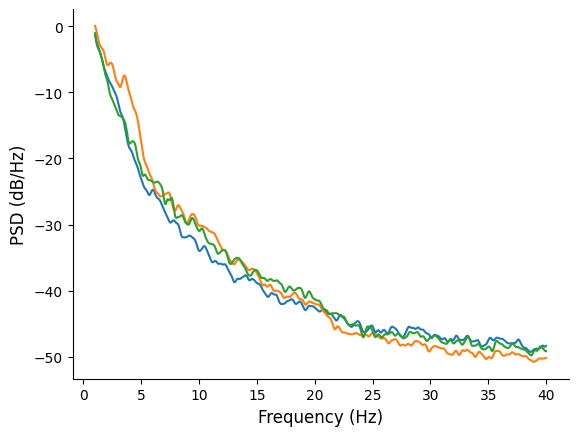

In [4]:

all_psd= []
all_session_name= []
# 指定要遍历的文件夹路径
folder_path = r"D:\code\YMa_datasets\food_tracking_data\Epidural"

# 使用os.walk()函数遍历文件夹及其子文件夹
for root, dirs, files in os.walk(folder_path):
    # 打印当前文件夹路径
    #print(f"当前文件夹: {root}")

    # 打印当前文件夹下的所有文件
    for file in files:
        #print(f"  文件: {file}")
        if file == "Motion.mat":
            # 打印文件的完整路径
            file_path = os.path.join(root, file)
            print(f"找到文件: {file_path}")
            motion_all_data_set,time = get_data(file_path)
            motion_all_data_set=np.array(motion_all_data_set)
            session_name = get_session_name(file_path)

            plot_motion(data=motion_all_data_set,
                        time=time,
                       plot_index = 'LSHO',
                       session_name =session_name)
            
            
            
             
            # data shape  time x axis
            f, t,psd= get_psd(data=motion_all_data_set,
                              sampling_rate=120,
                              bandwidth=[1,40],
                             plot_index = 'LSHO' )

            
            plot_psd(f=f, 
                     psd=psd)
            
            all_psd.append(psd)
            all_session_name.append(session_name)

# Difference of 3 coordinates  across sessions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


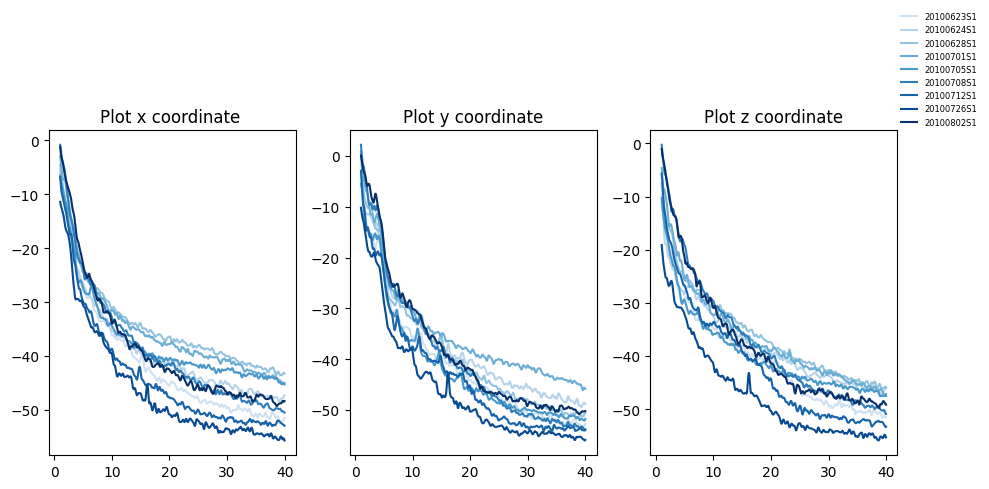

In [5]:
all_psd_copy = np.array(copy.deepcopy(all_psd))

# Generate colors using the Blues colormap
colors = plt.cm.Blues(np.linspace(0.2, 1, len(all_session_name)))

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

labels=['x coordinate ','y coordinate','z coordinate']

for i, ax in enumerate(axes):
    for j in range(all_psd_copy.shape[0]):
        ax.plot(f, all_psd_copy[j, i, :], label=all_session_name[j], color=colors[j])

    ax.set_title(f'Plot {labels[i]}')
    plt.legend(frameon=False,loc=[1,1], fontsize=6)
plt.tight_layout()

plt.show()